## 概述
神经网络翻译模型. 利用 `tf.contrib.legacy_seq2seq.model_with_buckets` 实现

In [1]:
from collections import Counter
import re
import time
import tensorflow as tf
from tensorflow.python.ops import variable_scope
import jieba
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

CPython 3.4.3
IPython 5.3.0

tensorflow 1.0.1
numpy 1.12.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.9.13-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
# 模型相关参数
cell_size = 100
embedding_size = 100
buckets = [(8, 8), (12, 12), (20, 20)]
# num_sampled = 300
# TODO: 怎样更合理地设置 buckets?

## 读入语料并处理

In [3]:
basedir = '^data/'
files = {'train': {'en': basedir + 'TED_en_train.txt',
                   'zh': basedir + 'TED_zh_train.txt'},
         'test': {'en': basedir + 'TED_en_test.txt',
                  'zh': basedir + 'TED_zh_test.txt'}}
lines_to_read = 100
VOCAB_MIN_FREQ = 1  # 计入词表的最小词频, 小于此值则记为 UNK

### 读取文本文件, tokenize 得到 sentences (word lists)

decoder inputs 在句子首尾分别添加特殊 token
* 句首的 <GO> Token 是为了喂给 decoder 的第一个 cell, 以便生成第一个词.  
* 句末的 <EOS> Token 相当于人为给模型提供一个句子结束的信号, 让模型自己学会何时结束句子.

In [4]:
_PAD, _GO, _EOS, _UNK = '<PAD>', '<GO>', '<EOS>', '<UNK>' 
_PAD_ID, _GO_ID, _EOS_ID, _UNK_ID = 0, 1, 2, 3
_START_VOCAB = (_PAD, _GO, _EOS, _UNK)

In [5]:
def en_tokenizer(sentence):
    """英文句子分词
    source: https://github.com/tensorflow/models/blob/master/tutorials/rnn/translate/data_utils.py
    """
    _word_split = re.compile("([.,!?\"':;)(])")
    words = []
    for space_separated_fragment in sentence.strip().split():
        words.extend(_word_split.split(space_separated_fragment))
    return [w for w in words if w]

def zh_tokenizer(sentence):
    '''中文句子分词'''
    return [w for w in jieba.cut(sentence.strip()) if w not in (' ', '\t', '\n')]
    # return [char for char in sentence.strip() if char not in (' ', '\t', '\n')]


def read_sentences(encoder_file, decoder_file, lines_to_read=None):
    """默认从英文到中文"""
    
    # 读取文件. lines_to_read 参数可用于小规模试验.
    with open(encoder_file, encoding='utf-8') as f:
        enc_lines = f.readlines()[:lines_to_read] if lines_to_read else f.readlines()
    with open(decoder_file, encoding='utf-8') as f:
        dec_lines = f.readlines()[:lines_to_read] if lines_to_read else f.readlines()
    assert len(enc_lines) == len(dec_lines)

    num_lines = len(enc_lines)
    
    encoder_sentences = []
    decoder_sentences = []
    
    for i in range(num_lines):
        enc_sentence = en_tokenizer(enc_lines[i])
        dec_sentence = zh_tokenizer(dec_lines[i])
        if enc_sentence and dec_sentence:
            encoder_sentences.append(enc_sentence)
            decoder_sentences.append(dec_sentence)
    return encoder_sentences, decoder_sentences


encoder_sentences, decoder_sentences = read_sentences(
    files['train']['en'], files['train']['zh'], lines_to_read=lines_to_read)
encoder_sentences_test, decoder_sentences_test = read_sentences(
    files['train']['en'], files['train']['zh'], lines_to_read=500)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.777 seconds.
Prefix dict has been built succesfully.


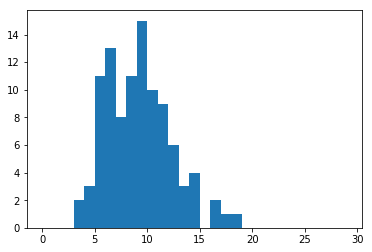

In [6]:
def plot_length_histogram(sentences):
    lengths = np.asarray([len(s) for s in sentences])
    plt.hist(lengths, bins=range(30));

plot_length_histogram(encoder_sentences)

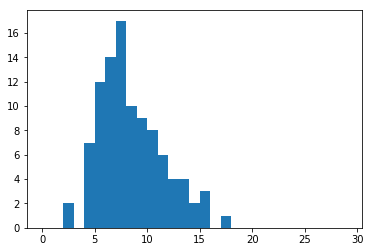

In [7]:
plot_length_histogram(decoder_sentences)

In [8]:
# def print_(lst):
#     for i in lst:
#         print(i)

# print_(encoder_sentences)
# print_(decoder_sentences)

### 由训练文件的 word lists 得到 vocab

In [9]:
def build_vocab(sentences):
    """生成词表. 前几个位置留给 _START_VOCAB 的特殊 token """
    vocab = list(_START_VOCAB)
    words_flat = [w for s in sentences for w in s]
    word_cnt = Counter(words_flat)
    for word, count in word_cnt.most_common():
        if count >= VOCAB_MIN_FREQ:
            vocab.append(word)
    return vocab

# vocab_xxx 相当于 demo 代码里的 reversed_vocab
vocab_enc = build_vocab(encoder_sentences)  # list: id -> word
vocab_dec = build_vocab(decoder_sentences)
num_encoder_symbols = len(vocab_enc)
num_decoder_symbols = len(vocab_dec)

# wod2id_xxx 相当于 demo 代码里的 vocab
word2id_enc = {w: i for i, w in enumerate(vocab_enc)}  # dict: word -> id
word2id_dec = {w: i for i, w in enumerate(vocab_dec)}

print(num_encoder_symbols, num_decoder_symbols)

307 353


### decoder inputs 句子首尾加 token

In [10]:
def add_tokens(sentences):
    """为 decoder 的输入语句增加首尾 token"""
    for i in range(len(sentences)):
        sentences[i] = [_GO] + sentences[i] + [_EOS]
    return sentences

decoder_sentences = add_tokens(decoder_sentences)
decoder_sentences_test = add_tokens(decoder_sentences_test)

In [11]:
# print_(encoder_sentences)
# print_(decoder_sentences)

In [12]:
# print_(encoder_sentences_test)
# print_(decoder_sentences_test)

### tokens -> ids -> bucketing -> padding

In [13]:
def bucket_and_pad(enc_sentences, dec_sentences, buckets, word2id_enc, word2id_dec):
    """
    - enc_sentences: A nested list of symbol str for encoding, length: batch_size
    - dec_sentences: A nested list of symbol str for decoding, length: batch_size
    - word2id_enc, word2id_dec: dict. symbol (str) -> index (int)
    
    Example: 
    ["hello", "world"] -> ["hi", "<EOS>"]
    ["cover", "me"] -> ["roger", "<EOS>"]
        
    Assume that index of "<PAD>" is 0

    Output:
    [[0, 0, <index of 'hello'>, <index of 'world'>], [0, 0, <index of 'cover'>, <index of 'me'>]],
    [[<index of 'hi'>, <index of 'EOS'>, 0, 0], [<index of 'roger'>, <index of 'EOS'>, 0, 0]]
    """
    def to_index(sentence, length, word2id, pad_from_start=True):
        ids = [_PAD_ID] * length
        l = len(sentence)
        if l < length:
            if pad_from_start:
                ids[(length - l):] = [word2id.get(w, _UNK_ID) for w in sentence]
            else:
                ids[:l] = [word2id.get(w, _UNK_ID) for w in sentence]
        else:
            ids = [word2id.get(w, _UNK_ID) for w in sentence[:length]]
        return ids
    
    num_sentences = len(enc_sentences)
    
    encoder_data = [[] for _ in range(len(buckets))]
    decoder_data = [[] for _ in range(len(buckets))]
    
    # bucketing. 此时 decoder_sentences 已加首尾 token.
    for i in range(num_sentences):
        for bucket_id, (encoder_size, decoder_size) in enumerate(buckets):
            if len(enc_sentences[i]) <= encoder_size and len(dec_sentences[i]) <= decoder_size:
                encoder_data[bucket_id].append(
                    to_index(enc_sentences[i], encoder_size, word2id_enc, True))
                decoder_data[bucket_id].append(
                    to_index(dec_sentences[i], decoder_size, word2id_dec, False))
                break
    
    return encoder_data, decoder_data


encoder_data, decoder_data = bucket_and_pad(
    encoder_sentences, decoder_sentences, buckets, word2id_enc, word2id_dec)
encoder_data_test, decoder_data_test = bucket_and_pad(
    encoder_sentences_test, decoder_sentences_test, buckets, word2id_enc, word2id_dec)

data_sizes = [len(encoder_data[i]) for i in range(len(buckets))]
data_sizes_dec = [len(decoder_data[i]) for i in range(len(buckets))]
assert data_sizes == data_sizes_dec

data_sizes_test = [len(encoder_data_test[i]) for i in range(len(buckets))]

data_sizes, data_sizes_test

([29, 47, 23], [208, 218, 70])

In [14]:
# encoder_data

In [15]:
# decoder_data

## 构建 seq2seq 模型


训练和生成(decoding) 这两个阶段需要共享变量


In [16]:
tf.reset_default_graph()
cell = tf.contrib.rnn.GRUCell(cell_size)
# 也可以试试 多层 rnn cell

### 按最大 bucket 的长度创建 placeholder 列表

注意在 bucketing 时, decoder inputs 已经做了首尾的 token: <GO> 和 <EOS>.

decoder_placeholder 长度取为 max_encoder_length. 即, 认为 decoder_inputs 包含首尾的 token?
*(或者, decoder_inputs 不应包含 EOS token?)*

target_placeholder 应该不包含 GO token, 所以长度应该减1 ?

In [17]:
max_encoder_length, max_decoder_length = buckets[-1]

In [18]:
encoder_placeholders = [
    tf.placeholder(tf.int32, shape=[None], name="encoder_%d" % i)
    for i in range(max_encoder_length)]
decoder_placeholders = [
    tf.placeholder(tf.int32, shape=[None], name="decoder_%d" % i)
    for i in range(max_decoder_length)]
target_placeholders = [
    tf.placeholder(tf.int32, shape=[None], name="target_%d" % i)
    for i in range(max_decoder_length)]
target_weights_placeholders = [
    tf.placeholder(tf.float32, shape=[None], name="decoder_weight_%d" % i)
    for i in range(max_decoder_length)]

### 利用 `model_with_buckets` 接口构建模型

In [19]:
def seq2seq_f(encoder_placeholders, decoder_placeholders, do_decode):
    # 可以在这里设置不同的 seq2seq 接口, 比如 embedding_attention_seq2seq
    return tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
        encoder_placeholders,
        decoder_placeholders,
        cell,
        num_encoder_symbols=num_encoder_symbols,
        num_decoder_symbols=num_decoder_symbols,
        embedding_size=embedding_size,
        output_projection=None,
        feed_previous=do_decode)

# def sampled_loss(labels, logits):
#     """参考: https://github.com/tensorflow/models/blob/master/tutorials/rnn/translate/data_utils.py"""
#     labels = tf.reshape(labels, [-1, 1])
#     # We need to compute the sampled_softmax_loss using 32bit floats to
#     # avoid numerical instabilities.
#     local_w_t = tf.cast(w_t, tf.float32)
#     local_b = tf.cast(b, tf.float32)
#     local_inputs = tf.cast(logits, tf.float32)
#     return tf.nn.sampled_softmax_loss(
#         weights=proj_w_t,
#         biases=proj_b,
#         labels=labels,
#         inputs=logits,
#         num_sampled=num_sampled,
#         num_classes=num_decoder_symbols)

# proj_w_t = tf.get_variable("proj_w", [num_decoder_symbols, cell_size], dtype=tf.float32)
# proj_w = tf.transpose(proj_w_t)
# proj_b = tf.get_variable("proj_b", [num_decoder_symbols], dtype=tf.float32)
# output_projection = (proj_w, proj_b)

outputs, losses = tf.contrib.legacy_seq2seq.model_with_buckets(
    encoder_placeholders, decoder_placeholders, target_placeholders,
    target_weights_placeholders, buckets, lambda x, y: seq2seq_f(x, y, False),
    softmax_loss_function=None)

losses 是个列表, 各元素分别为不同 bucket 的 loss. 用 losses 求和后传给 train_step 会报错, 原因可能是: 较大 bucket 的 losses 需要 feed 更多的 placeholder, 在用较小 bucket 的数据来训练时, 无法提供.

实际上不同 bucket 的训练是相对独立的, 因此可以用不同的 loss 传给 optimizer 用于不同 bucket 的训练. 参见 [demon386/tf_bucket_seq2seq/bucketmodel.py](https://github.com/demon386/tf_bucket_seq2seq/blob/master/bucketmodel.py) 之 [L173](https://github.com/demon386/tf_bucket_seq2seq/blob/master/bucketmodel.py#L173), [L243](https://github.com/demon386/tf_bucket_seq2seq/blob/master/bucketmodel.py#L243)

## 准备 feed 数据

注意 embedding_rnn_seq2seq 接收的 encoder_inputs 形状为 `A list of 1D int32 Tensors of shape [batch_size]`. 为此, 可以用 `list(zip(*lst))` 来对 nested list 进行"转置", 得到需要的形状.

In [20]:
def left_shift(decoder_inputs):
    """generate targets grom decoder_inputs"""
    return [list(input_[1:]) + [_PAD_ID] for input_ in decoder_inputs]

def get_bucket_inputs(encoder_data, decoder_data, bucket_id):
    encoder_inputs = encoder_data[bucket_id]
    decoder_inputs = decoder_data[bucket_id]
    return (encoder_inputs, decoder_inputs)

def get_batch_inputs(encoder_data, decoder_data, bucket_id, batch_start, batch_size):
    encoder_inputs = encoder_data[bucket_id][batch_start : batch_start+batch_size]
    decoder_inputs = decoder_data[bucket_id][batch_start : batch_start+batch_size]
    return (encoder_inputs, decoder_inputs)

def generate_feed_dict(inputs_tuple, encoder_size, decoder_size):
    """对 inputs 做转置, 并喂给 placeholder 列表, 得到 feed_dict"""
    encoder_inputs, decoder_inputs = inputs_tuple
    encoder_inputs = list(zip(*encoder_inputs))
    target_inputs = list(zip(*left_shift(decoder_inputs)))
    decoder_inputs = list(zip(*decoder_inputs)) 
    
    feed_dict = dict()
    # Prepare input data
    for i in range(encoder_size):
        # 这里用 placeholder 或者 placeholder.name 都可以
        feed_dict[encoder_placeholders[i].name] = np.asarray(encoder_inputs[i], dtype=int)
    for i in range(decoder_size):
        feed_dict[decoder_placeholders[i].name] = np.asarray(decoder_inputs[i], dtype=int)
        feed_dict[target_placeholders[i].name] = np.asarray(target_inputs[i], dtype=int)        
        # 这里使用 weights 把 <PAD> 的损失屏蔽了
        feed_dict[target_weights_placeholders[i].name] = np.asarray(
            [float(idx != _PAD_ID) for idx in target_inputs[i]], dtype=float)
    return feed_dict

## 训练


In [21]:
# 训练相关参数
epochs = 500
print_loss_every = 5
learning_rate = 3
batch_size = 50

In [29]:
# 把不同 bucket 的 loss 分别传给 optimizer, 得到不同的 train_step. 不知可否?
train_steps = [tf.train.AdagradOptimizer(learning_rate).minimize(losses[i]) 
               for i in range(len(buckets))]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training
start_time = time.time()
try:
    print('Epoch ' + ''.join(['bucket-{} '.format(i) for i in range(len(buckets))]))
    for i in range(epochs):
        if i % print_loss_every == 0:
            print('\n{: 4d}'.format(i), end=' ')

        for bucket_id in range(len(buckets)):
            cur_data_size = data_sizes[bucket_id]
            if cur_data_size == 0:
                continue  # 某个 bucket 为空的特殊情形
            encoder_size, decoder_size = buckets[bucket_id]
            
            # 输出 loss 过程信息
            if i % print_loss_every == 0:
                bucket_inputs = get_bucket_inputs(encoder_data, decoder_data, bucket_id)
                bucket_feed = generate_feed_dict(bucket_inputs, encoder_size, decoder_size)
                loss_val = sess.run(losses[bucket_id], feed_dict=bucket_feed)
                print('{: 8.4f}'.format(loss_val), end=' ')
            
            # 训练
            for batch_start in range(0, cur_data_size, batch_size):
                batch_inputs = get_batch_inputs(
                    encoder_data, decoder_data, bucket_id, batch_start, batch_size)
                batch_feed = generate_feed_dict(batch_inputs, encoder_size, decoder_size)
                sess.run(train_steps[bucket_id], feed_dict=batch_feed)
except KeyboardInterrupt:
    print('\nKeyboardInterrup')

print('Train time: {} s'.format(time.time() - start_time))
# plt.plot(range(0, i, print_loss_every), loss_history);

Epoch bucket-0 bucket-1 bucket-2 

   0   5.8737   5.4940   7.9868 
   5  16.6137  18.6926  16.6111 
  10   8.4404  12.8896  12.0718 
  15   5.9407   7.1941   4.9982 
  20   4.8046   5.4349   4.6590 
  25   2.9296   3.7810   2.8583 
  30   1.5386   2.7664   3.4946 
  35   1.0132   1.3530   1.6074 
  40   0.5756   1.0957   0.6527 
  45   0.1591   0.4443   0.3440 
  50   0.3563   0.6183   0.3331 
  55   0.0729   0.2131   0.2162 
  60   0.0763   0.1663   0.1700 
  65   0.0556   0.1272   0.1328 
  70   0.0520   0.1062   0.1209 
  75   0.0447   0.0918   0.0964 
  80   0.0397   0.0787   0.0949 
  85   0.0386   0.0749   0.0812 
  90   0.0378   0.0669   0.0807 
  95   0.0379   0.0647   0.0717 
 100   0.0364   0.0590   0.0719 
 105   0.0365   0.0576   0.0654 
 110   0.0350   0.0534   0.0655 
 115   0.0353   0.0526   0.0609 
 120   0.0337   0.0493   0.0601 
 125   0.0342   0.0487   0.0574 
 130   0.0327   0.0459   0.0559 
 135   0.0334   0.0456   0.0544 
 140   0.0319   0.0433   0.0522 
 145   0

## 测试/decode

decoding 过程中, 因为 feed_previous 为 true, 所以 `decoder_inputs` 只用到第一个元素, 后面的都不需要.

In [40]:
def cut_at_eos(sentence):
    if _EOS in sentence:        
        return sentence[:sentence.index(_EOS)+1]
    else:
        return sentence

def no_prepending_pad(sentence):
    for i in range(len(sentence)):
        if sentence[i] != _PAD:
            return sentence[i:]

with variable_scope.variable_scope(variable_scope.get_variable_scope(), reuse=True):
    outputs, _ = tf.contrib.legacy_seq2seq.model_with_buckets(
        encoder_placeholders, decoder_placeholders, target_placeholders,
        target_weights_placeholders, buckets, lambda x, y: seq2seq_f(x, y, True),
        softmax_loss_function=None)
    
    for bucket_id in range(len(buckets)):
        print('\n** bucket {}'.format(bucket_id))
        cur_data_size = data_sizes_test[bucket_id]
        if cur_data_size == 0:
            continue  # 某个 bucket 为空的特殊情形

        encoder_size, decoder_size = buckets[bucket_id]
        bucket_inputs_test = get_bucket_inputs(encoder_data_test, decoder_data_test, bucket_id)
        bucket_feed = generate_feed_dict(bucket_inputs_test, encoder_size, decoder_size)
        
        output_bucket = np.zeros((cur_data_size, decoder_size), dtype=int)  
        # output_bucket 用于记录当前bucket输出值, 形状是 outputs 的"转置"
    
        for i in range(decoder_size):
            prob = outputs[bucket_id][i]  # 第i个词的概率输出
            output_bucket[:, i] = np.argmax(sess.run(prob, feed_dict=bucket_feed), axis=1)
        
        # for j in range(cur_data_size):
        for j in range(10):  # 只看 bucket 里的前几个句子
            sen = [vocab_dec[output_bucket[j, k]] for k in range(decoder_size)]
            input_ = [vocab_enc[i] for i in encoder_data_test[bucket_id][j]]
            target_ = [vocab_dec[i] for i in decoder_data_test[bucket_id][j][1:]]
            input_ = no_prepending_pad(input_)
            sen = cut_at_eos(sen)
            target_ = cut_at_eos(target_)
            print(' input: ', ' '.join(input_))
            print('output: ', ' '.join(sen))
            print('target: ', ' '.join(target_))
            print()


** bucket 0
 input:  And those simple themes aren ' t really
output:  这些 简单 的 话题 确实 不是 <EOS>
target:  这些 简单 的 话题 确实 不是 <EOS>

 input:  and we build from there ,
output:  从 这里 出发 ， <EOS>
target:  从 这里 出发 ， <EOS>

 input:  Cannery Row , at the time ,
output:  那时 的 坎纳里 鲁夫 ， <EOS>
target:  那时 的 坎纳里 鲁夫 ， <EOS>

 input:  had the biggest industrial
output:  有着 西海岸 最大 的 <EOS>
target:  有着 西海岸 最大 的 <EOS>

 input:  canning operation on the west coast .
output:  工业化 罐头 工厂 。 <EOS>
target:  工业化 罐头 工厂 。 <EOS>

 input:  We piled enormous amounts of pollution
output:  我们 堆积 了 大量 的 污染物 <EOS>
target:  我们 堆积 了 大量 的 污染物 <EOS>

 input:  into the air and into the water .
output:  在 空气 中 和 水中 <EOS>
target:  在 空气 中 和 水中 <EOS>

 input:  wrote in the 1940s that
output:  在 二十世纪 40 年代 指出 ， <EOS>
target:  在 二十世纪 40 年代 指出 ， <EOS>

 input:  were so bad they turned
output:  特别 难闻 <EOS>
target:  特别 难闻 <EOS>

 input:  People working in these canneries
output:  工作 在 罐头厂 的 人们 <EOS>
target:  工作 在 罐头厂 的 人们 <EOS>


** bucke

## 试验

读入 1000 句. learning_rate = 3. 约 170 步时, cost 稳定到 0.1-0.2  
耗时 1500 * 170/520 = 500 s


## Note

难点: 
- seq2seq 接收的输入形式很特别, 与之前遇到的问题有很大区别:
  + 两种输入: encoder_inputs, decoer_inputs.
  + decoder_inputs 在训练和生成时用法不同.
  + 输入都是不同时间步的 list of tensors, 需要做一次转置.
- bucketing 让代码的复杂度增加了一个数量级

todo:
- [x] 生成时遇到 EOS 就停下来.
- 如何准确处理 decoder_input 的长度? +1/-1/shift 之类.
- UNK 的处理
    - [此文](http://suriyadeepan.github.io/2016-12-31-practical-seq2seq/) 建议 UNK 在语料(不是词表)中的比例控制在 5% 以内.
- 计算效率.
    - 尝试参照 [models/seq2seq_model.py](https://github.com/tensorflow/models/blob/master/tutorials/rnn/translate/seq2seq_model.py) 实施 sampled loss, 未成功


## ChangeLog

* v.pre
    * 感觉大的框架没啥问题. 但翻译结果惨不忍睹. 改进之路漫漫...
    * UNK 太多, 需要处理一下.
* maybe
    * 试试多层 cell
    * 试试字模型
    * 用 class 组织代码